In [1]:
import os
import numpy as np
import matplotlib
from matplotlib import animation
from matplotlib import pyplot as plt
from tqdm import tqdm

from envs import Maze
from utils import plot_policy, plot_tabular_cost_to_go, test_env, plot_stats, seed_everything

In [2]:
import gym

# Create the environment

In [3]:
env = gym.make('MountainCar-v0')
seed_everything(env)
env.reset()

array([-0.4452088,  0.       ], dtype=float32)

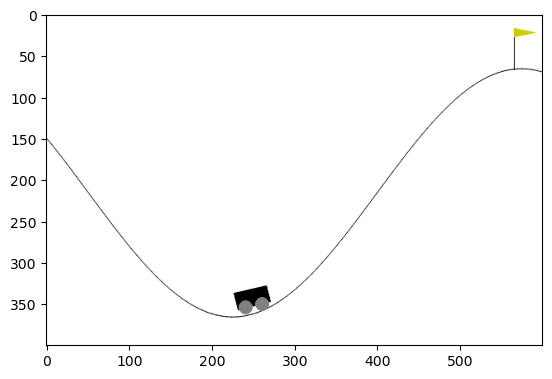

In [4]:
frame = env.render(mode='rgb_array')
plt.imshow(frame)

# Create the state aggregation wrapper

In [5]:
class StateAggregationEnv(gym.ObservationWrapper):

    def __init__(self, env, bins, low, high):
        # low = [-1.2, -0.07], high = [0.6, 0.7], bins = [20, 20]
        super().__init__(env) 
        self.buckets = [np.linspace(l, h, b - 1) for l, h, b in zip(low, high, bins)]
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist())

    def observation(self, state):
        # [-1.2, 0] -> (4, 3)
        indicies = tuple(np.digitize(cont, buck) for cont, buck in zip(state, self.buckets))
        return indicies

In [6]:
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
saenv = StateAggregationEnv(env, bins=bins, low=low, high=high)

In [7]:
saenv.buckets

[array([-1.20000005, -1.10000004, -1.00000004, -0.90000004, -0.80000003,
        -0.70000003, -0.60000002, -0.50000002, -0.40000002, -0.30000001,
        -0.20000001, -0.1       ,  0.        ,  0.1       ,  0.20000001,
         0.30000001,  0.40000002,  0.50000002,  0.60000002]),
 array([-0.07      , -0.06222222, -0.05444444, -0.04666667, -0.03888889,
        -0.03111111, -0.02333333, -0.01555556, -0.00777778,  0.        ,
         0.00777778,  0.01555556,  0.02333333,  0.03111111,  0.03888889,
         0.04666667,  0.05444444,  0.06222222,  0.07      ])]

# Compare the original environment to the one with aggregated states

In [8]:
print(f"Modified observation space: {saenv.observation_space}, \n\
Sample state: {saenv.observation_space.sample()}")

Modified observation space: MultiDiscrete([20 20]), 
Sample state: [ 3 12]


In [9]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.observation_space.sample()}")

Original observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Sample state: [ 0.1931209  -0.00855702]


# Create the Q(s, a) table

In [10]:
action_values = np.zeros((20, 20, 3))

# Create the e-greedy policy

In [11]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

# Test the SARSA algorithm on the modified environment

In [12]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = { "Returns": [] }
    
    for episode in tqdm(range(1, episodes + 1)):
        state = saenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0

        while not done:
            next_state, reward, done, _ = saenv.step(action)
            next_action = policy(next_state, epsilon)

            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action]
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [13]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:06<00:00, 299.50it/s]


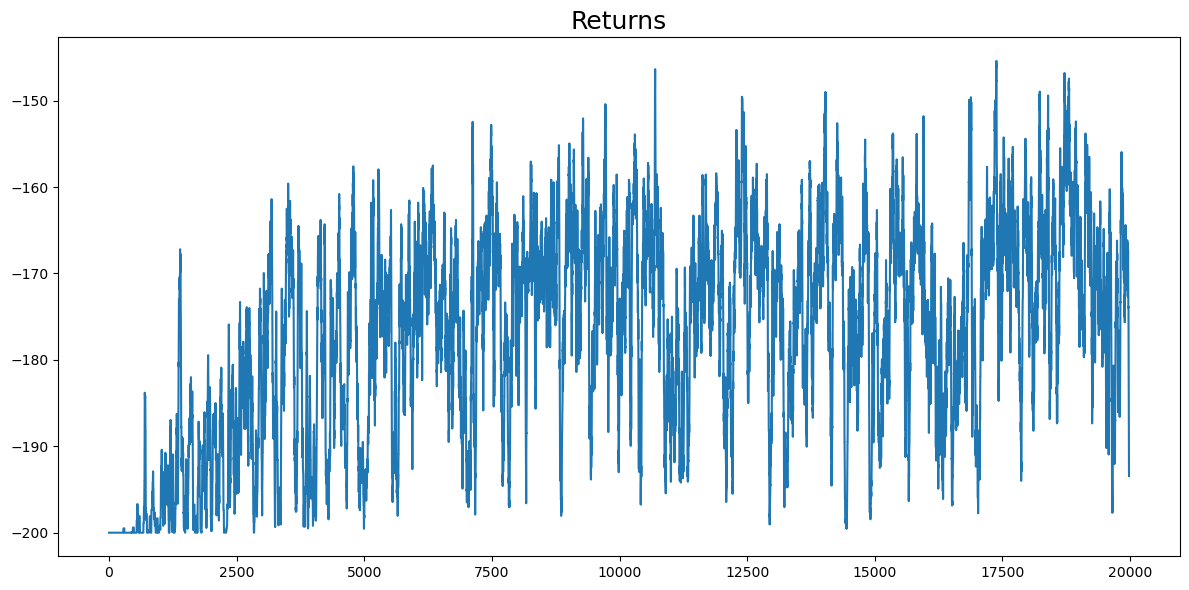

In [14]:
plot_stats(stats)

# Plot the learned policy

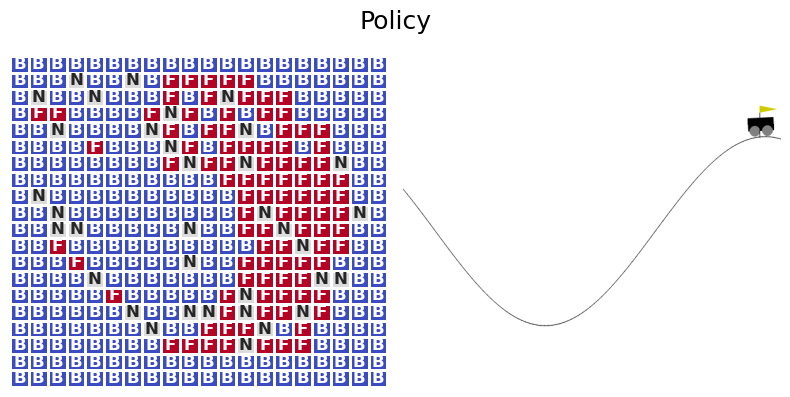

In [18]:
plot_policy(action_values, env.render(mode="rgb_array"),
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

# Plot the cost to go

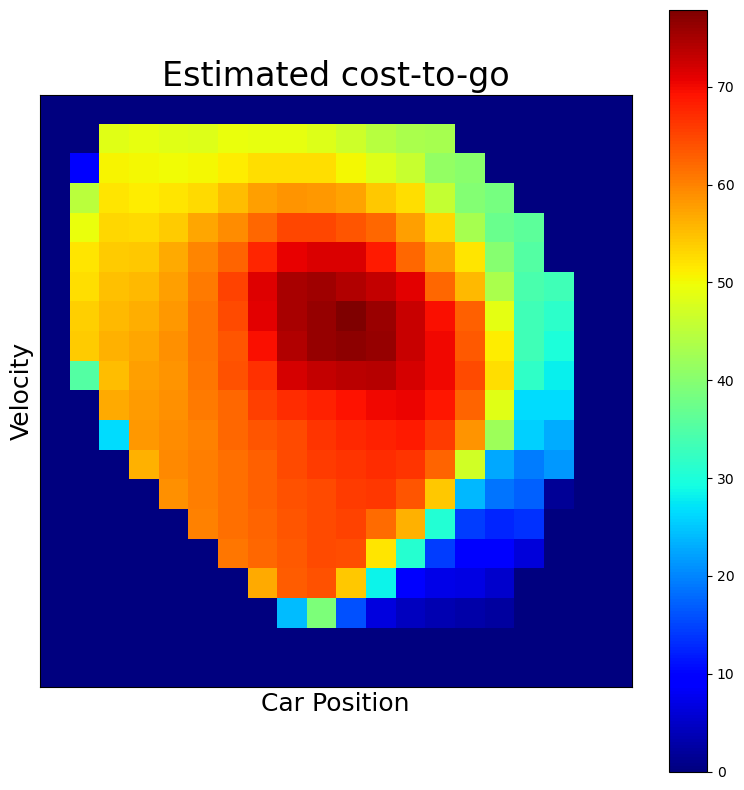

In [19]:
plot_tabular_cost_to_go(action_values, xlabel="Car Position", ylabel="Velocity")

# Test the resuling policy

In [15]:
from utils import test_agent

In [16]:
test_agent(saenv, policy, episodes=1)